<a href="https://colab.research.google.com/github/ANadalCardenas/attention/blob/main/wildfire_model_version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **First version model**

I have prepared a very basic proposal. I assumed that we would use the Sentinel-2 training dataset, which includes all seven bands. However, this is just an assumption.

# Imports and environment setup:

In [ ]:
# Numerical operations and array handling
import numpy as np

# TensorFlow and Keras for building and training the CNN
import tensorflow as tf
from tensorflow.keras import layers, models

# Plotting training curves
import matplotlib.pyplot as plt

# Monitoring
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the dataset:

In the real project:
 - Loads Sentinel-2 image patches and labels

 - Each sample is a 64*64 patch with 7 spectral bands

 - Labels are binary:

   - 0 → no wildfire

   - 1 → wildfire

Now, we simulate data, in the real project, this will come from Copernicus Data Space (or whatever we decide)

In [ ]:
# Number of samples (for example purposes only)
N = 1000

# X contains image patches:
# shape = (number_of_samples, height, width, bands)
# Now, we will atke into account all of 7 bands, but also could be less than 7
X = np.random.rand(N, 64, 64, 7).astype(np.float32)

# y contains labels:
# 0 = no fire, 1 = fire
y = np.random.randint(0, 2, size=(N,))

# Train / validation split

Splits the dataset into:

80% training (*ask to Amanda whats the best split*)

20% validation (*the same*)

Validation data is never seen during training.

In [ ]:
# Index where we split the dataset
split_index = int(0.8 * N)

# Training data
X_train = X[:split_index]
y_train = y[:split_index]

# Validation data
X_val = X[split_index:]
y_val = y[split_index:]

# Band-wise normalization
We must do that because Sentinel-2 bands have very different value ranges. Each band measures different physical phenomena, so the numerical values are not comparable.If one band has much larger values, it dominates the sum. So, we must do the normalization because:

 - Improves convergence

 - Makes training stable

 - Is essential for CNNs

 - Normalizes each band independently

 - Applies:  $x_{\text{norm}} = \frac{x - \mu}{\sigma}$


In [ ]:
def normalize_per_band(X):
    """
    Normalize each spectral band independently.

    X shape: (N = 1000, H = 64, W = 64, C = 7)
    """
    # Create a copy to avoid modifying the original data
    X_normalized = X.copy()

    # Loop over each spectral band
    for band in range(X.shape[-1]):
        # Compute mean of this band. With this annotation X[..., band].shape = (N, H, W)
        mean = X[..., band].mean()

        # Compute standard deviation (small value added to avoid division by zero)
        std = X[..., band].std() + 1e-6

        # Normalize the band
        X_normalized[..., band] = (X[..., band] - mean) / std

    return X_normalized


# CNN + MaxPooling model (from scratch)
This CNN takes an input patch (64, 64, 7) and outputs a probability between 0 and 1:

Close to 1 → likely fire

Close to 0 → likely no fire

*Maybe, we can improve this part using logids. We can ask to Amanda as well as a recomendation of the number of layers*

In [ ]:
# Create a CNN model as a stack of layers
model = models.Sequential([

    # Input shape: 64x64 patch with 7 spectral bands
    layers.Input(shape=(64, 64, 7)),

    # ---- Block 1 ----
    # Conv2D learns local patterns; 16 filters means 16 pattern detectors.
    # padding = "same". It means that the output feature map has the same height and width as the input.
    layers.Conv2D(16, 3, padding='same', activation='relu'),

    # MaxPooling reduces resolution and computation (64x64 -> 32x32)
    layers.MaxPooling2D(2),

    # ---- Block 2 ----
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),  # 32x32 -> 16x16

    # ---- Block 3 ----
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),  # 16x16 -> 8x8

    # GlobalAveragePooling compresses (8, 8, 64) into (64,)
    # This is fast and avoids many parameters
    layers.GlobalAveragePooling2D(),

    # Final classifier:
    # Sigmoid converts the output into a probability in [0, 1]
    layers.Dense(1, activation='sigmoid')
])


# Compile the model

 - Adam optimizer updates the CNN weights

 - Binary cross-entropy is used for fire/no-fire classification

 - Accuracy is monitored


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Learning rate controls step size
    loss='binary_crossentropy',                              # Standard loss for sigmoid binary classifier
    metrics=['accuracy']                                     # Monitor accuracy during training.
                                                             # We can add more metrics to monitoring
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 16)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,225 (94.63 KB)

 Trainable params: 24,225 (94.63 KB)

 Non-trainable params: 0 (0.00 B)

I hava added this new version of the model. I have detected that the training is much slower with this model (13min vs ). We will have to see how better it is and decide which modifications benefits us more.

In [ ]:
model = models.Sequential([

    # Input: 64x64 image patch with 7 Sentinel-2 spectral bands(e.g. RGB, NIR, SWIR, etc.)
    layers.Input(shape=(64, 64, 7)),

    # 1x1 Convolution for spectral band re-weighting
    # This allows the network to learn which spectral bands (e.g. NIR / SWIR) are more informative for wildfire detection
    # without mixing spatial information.
    layers.Conv2D(16, kernel_size=1, activation='relu'),

    # ---------------------------------------------------------
    # Block 1: Low-level spatial feature extraction
    # Learns simple patterns such as edges, small hotspots, or textures.
    layers.Conv2D(32, kernel_size=3, padding='same'),

    # Batch Normalization stabilizes training by normalizing activations,
    # which is especially useful for multi-spectral satellite data
    layers.BatchNormalization(),

    # ReLU introduces non-linearity, enabling the model to learn complex patterns
    layers.Activation('relu'),

    # MaxPooling reduces spatial resolution (64x64 -> 32x32), decreasing computation and increasing the receptive field
    layers.MaxPooling2D(pool_size=2),

    # ---------------------------------------------------------
    # Block 2: Mid-level feature extraction
    # Captures larger spatial structures such as fire clusters or smoke regions.
    layers.Conv2D(64, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    # Further spatial downsampling (32x32 -> 16x16)
    layers.MaxPooling2D(pool_size=2),

    # ---------------------------------------------------------
    # Block 3: High-level semantic features
    # Detects more abstract patterns related to wildfire signatures.
    layers.Conv2D(128, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    # Downsampling (16x16 -> 8x8)
    layers.MaxPooling2D(pool_size=2),

    # ---------------------------------------------------------
    # Global Average Pooling converts the 8x8x128 feature map into a single 128-dimensional feature vector.
    # This reduces the number of parameters and helps prevent overfitting.
    layers.GlobalAveragePooling2D(),

    # Dropout randomly disables neurons during training, improving generalization and reducing overfitting,
    # which is common in satellite imagery tasks.
    layers.Dropout(0.3),

    # ---------------------------------------------------------
    # Final classification layer
    # A single neuron with sigmoid activation outputs the probability of wildfire presence in the image patch.
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Binary Focal Cross-Entropy is well-suited for imbalanced datasets,
    # such as wildfire detection where "fire" pixels are rare.
    loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0),

    # Metrics beyond accuracy are critical for wildfire detection:
    # - Precision: how many predicted fires are correct
    # - Recall: how many actual fires are detected (very important)
    # - AUC: overall separability between fire and non-fire
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ]
)


# Train the model

Fits the CNN to the training data and checks progress on validation data after each epoch.

In [ ]:
history = model.fit(
    X_train, y_train,                    # Training patches and labels
    validation_data=(X_val, y_val),      # Validation patches and labels
    epochs=50,                           # Number of training epochs
    batch_size=32                        # Samples per batch
)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.5338 - loss: 0.7036 - val_accuracy: 0.5050 - val_loss: 0.6938
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.5336 - loss: 0.6910 - val_accuracy: 0.5050 - val_loss: 0.6958
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5322 - loss: 0.6917 - val_accuracy: 0.5050 - val_loss: 0.6951
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.5192 - loss: 0.6927 - val_accuracy: 0.5050 - val_loss: 0.6937
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.5152 - loss: 0.6922 - val_accuracy: 0.5050 - val_loss: 0.6960
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.5092 - loss: 0.6948 - val_accuracy: 0.5050 - val_loss: 0.6944
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.5480 - loss: 0.6895 - val_accuracy: 0.5050 - val_loss: 0.6941
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5233 - loss: 0.6923 - val_accuracy: 0.

# Training curves (optional but useful)

Plots training and validation accuracy to detect overfitting.

In [ ]:


plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


KeyError: 'accuracy'

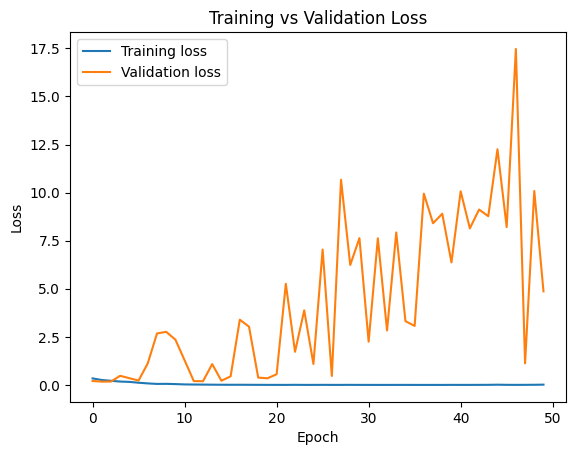

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


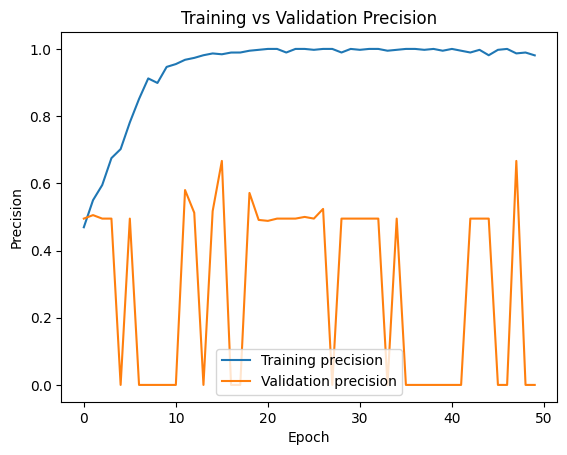

In [ ]:
plt.figure()
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Training vs Validation Precision")
plt.legend()
plt.show()


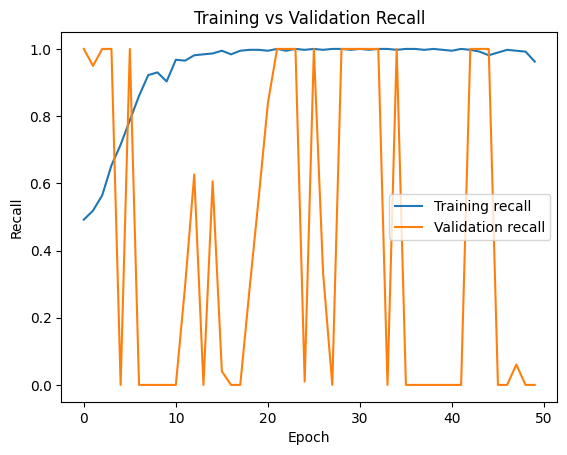

In [ ]:
plt.figure()
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Validation recall')
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Training vs Validation Recall")
plt.legend()
plt.show()


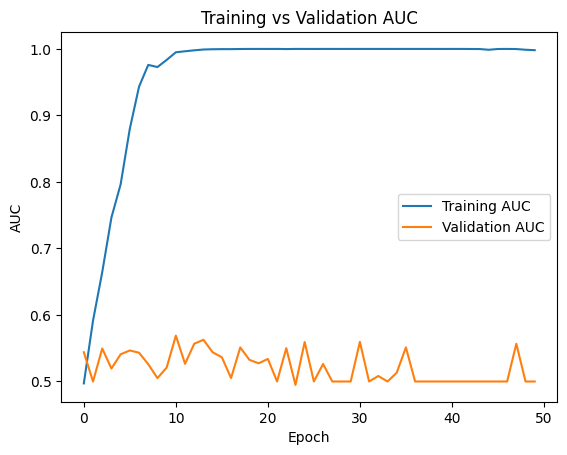

In [ ]:
plt.figure()
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training vs Validation AUC")
plt.legend()
plt.show()


# Inference (predictions)

In [ ]:
# Select a single patch (batch size 1)
patch = X_val[0:1]  # Shape: (1, 64, 64, 7)

# Predict returns probability directly because of sigmoid
prob_fire = model.predict(patch)[0, 0]

print("Fire probability:", prob_fire)

# Convert probability into a final decision using a threshold (Maybe we must try different tresholds)
if prob_fire > 0.5:
    print("Wildfire detected")
else:
    print("No wildfire detected")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Fire probability: 3.275492e-05
No wildfire detected


Batch prediction on many patches:

In [ ]:
# Predict probabilities for all validation patches
probs = model.predict(X_val).reshape(-1)     # Shape: (N,)

# Convert probabilities to hard class predictions (0/1)
preds = (probs > 0.5).astype(int)

# Compute accuracy manually
acc = (preds == y_val).mean()

print("Manual validation accuracy:", acc)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Manual validation accuracy: 0.505


# Evaluation

In [ ]:
# Número de mostres per al conjunt de prova
# Num of samples, 20% of the total
N_test = 200

# Simulation of test patches
X_test = np.random.rand(N_test, 64, 64, 7).astype(np.float32)

# y_test contains random labels (fire/no fire)
y_test = np.random.randint(0, 2, size=(N_test,))

print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_test: {y_test.shape}")

Shape de X_test: (200, 64, 64, 7)
Shape de y_test: (200,)


In [ ]:
# Normalization of test data
X_test_normalized = normalize_per_band(X_test)

print("Test data normalized.")

Test data normalized.


In [ ]:
test_loss, test_precision, test_recall, test_auc = model.evaluate(
    X_test_normalized,
    y_test,
    verbose=1
)

print("Test loss:", test_loss)
print("Test precision:", test_precision)
print("Test recall:", test_recall)
print("Test AUC:", test_auc)



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - auc: 0.5000 - loss: 40.5930 - precision: 0.0000e+00 - recall: 0.0000e+00
Test loss: 42.68479537963867
Test precision: 0.0
Test recall: 0.0
Test AUC: 0.5


# More monitoring metrics

In [ ]:
# Predict probabilities on test set
test_probs = model.predict(X_test).reshape(-1)

# Convert probabilities to predictions
test_pred = (test_probs > 0.5).astype(int)

print("Precision:", precision_score(y_test, test_pred))
print("Recall:", recall_score(y_test, test_pred))
print("F1-score:", f1_score(y_test, test_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step 
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
